# Analysis of codon usage preferences in tissue-specific exons

In [1]:
from pybedtools import Interval
import pyranges as pr
import pandas as pd
import numpy as np
from plotnine import *
from kipoiseq.extractors import FastaStringExtractor
from data_utils.sequence_utils import rc_dna, cut_seq, codons_count, ALL_CODONS_NAMES
from scipy.stats import spearmanr, pearsonr
#pd.set_option('display.max_columns', None)  
data_path = '../../data/'

Load the gtex psi data from ascot (this data can be downloaded at:http://snaptron.cs.jhu.edu/data/ascot/). They use gencode version 25.

In [2]:
# ascot_gtex_psi_df = pd.read_csv('http://snaptron.cs.jhu.edu/data/ascot/gtex_psi.csv.gz')
ascot_gtex_psi_df = pd.read_csv(data_path + 'gtex_psi.csv.gz')

In [3]:
ascot_gtex_psi_df

,exon_id,cassette_exon,alternative_splice_site_group,linked_exons,mutually_exclusive_exons,exon_strand,exon_length,gene_type,gene_id,gene_symbol,...,Not Sun Exposed - Skin,Sun Exposed (Lower leg) - Skin,Ileum - Small Intestine,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,GT_00001,Yes,No,No,No,-,87,protein_coding,ENSG00000121410.11,A1BG,...,13.199024,12.135550,7.189542,12.656651,10.497812,8.512642,18.084153,8.528845,7.439244,9.999865
1,GT_00002,Yes,No,No,No,+,104,antisense,ENSG00000268895.5,A1BG-AS1,...,33.590115,30.011723,37.515735,36.528732,33.971923,27.981121,33.010940,34.812014,31.081544,40.580524
2,GT_00003,No,3',Yes,No,-,182|206,protein_coding,ENSG00000148584.14,A1CF,...,-1.000000,-1.000000,99.803153,100.000000,100.000000,-1.000000,-1.000000,-1.000000,-1.000000,100.000000
3,GT_00004,No,3',Yes,No,-,2423,protein_coding,ENSG00000148584.14,A1CF,...,-1.000000,-1.000000,99.791151,100.000000,100.000000,-1.000000,-1.000000,-1.000000,-1.000000,100.000000
4,GT_00005,Yes,No,No,No,-,165,protein_coding,ENSG00000148584.14,A1CF,...,-1.000000,-1.000000,93.836895,96.076955,98.374384,-1.000000,-1.000000,-1.000000,-1.000000,98.235610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80012,GT_80013,Yes,No,No,No,-,135,protein_coding,ENSG00000036549.12,ZZZ3,...,99.757412,99.780126,99.660532,99.583549,99.803747,99.740020,99.789398,99.835786,99.942395,99.930742
80013,GT_80014,Yes,No,No,No,-,96,protein_coding,ENSG00000036549.12,ZZZ3,...,98.868129,99.219080,99.530059,99.385511,99.219567,99.613922,99.133360,98.820583,98.126001,97.738396
80014,GT_80015,Yes,No,No,No,-,78,protein_coding,ENSG00000036549.12,ZZZ3,...,0.274495,0.445183,0.548740,1.155228,0.627100,2.843627,0.198609,0.225228,0.215826,0.813760
80015,GT_80016,Yes,No,No,No,-,63,protein_coding,ENSG00000036549.12,ZZZ3,...,91.125850,92.618619,90.892531,94.130899,92.347397,88.337036,89.848202,89.865645,88.434325,90.356385


In [4]:
tissues = list(ascot_gtex_psi_df.columns[-56:])
tissues

['Retina - Eye',
 'RPE/Choroid/Sclera - Eye',
 'Subcutaneous - Adipose',
 'Visceral (Omentum) - Adipose',
 'Adrenal Gland',
 'Aorta - Artery',
 'Coronary - Artery',
 'Tibial - Artery',
 'Bladder',
 'Amygdala - Brain',
 'Anterior cingulate - Brain',
 'Caudate nucleus - Brain',
 'Cerebellar Hemisphere - Brain',
 'Cerebellum - Brain',
 'Cortex - Brain',
 'Frontal Cortex - Brain',
 'Hippocampus - Brain',
 'Hypothalamus - Brain',
 'Nucleus accumbens - Brain',
 'Putamen - Brain',
 'Spinal cord (C1) - Brain',
 'Substantia nigra - Brain',
 'Mammary Tissue - Breast',
 'EBV-xform lymphocytes - Cells',
 'Leukemia (CML) - Cells',
 'Xform. fibroblasts - Cells',
 'Ectocervix - Cervix',
 'Endocervix - Cervix',
 'Sigmoid - Colon',
 'Transverse - Colon',
 'Gastroesoph. Junc. - Esophagus',
 'Mucosa - Esophagus',
 'Muscularis - Esophagus',
 'Fallopian Tube',
 'Atrial Appendage - Heart',
 'Left Ventricle - Heart',
 'Cortex - Kidney',
 'Liver',
 'Lung',
 'Minor Salivary Gland',
 'Skeletal - Muscle',
 'Tibi

Replace -1 with nan and get psi into 0-1 scale:

In [5]:
ascot_gtex_psi_df.loc[:, tissues] = ascot_gtex_psi_df.loc[:, tissues].replace(-1, np.nan)
ascot_gtex_psi_df.loc[:, tissues] = ascot_gtex_psi_df.loc[:, tissues] / 100.

In [6]:
cassete_exon_coding_df = ascot_gtex_psi_df[(ascot_gtex_psi_df['cassette_exon']=='Yes') & (ascot_gtex_psi_df['gene_type']=='protein_coding')].reset_index(drop=True)
cassete_exon_coding_df

,exon_id,cassette_exon,alternative_splice_site_group,linked_exons,mutually_exclusive_exons,exon_strand,exon_length,gene_type,gene_id,gene_symbol,...,Not Sun Exposed - Skin,Sun Exposed (Lower leg) - Skin,Ileum - Small Intestine,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,GT_00001,Yes,No,No,No,-,87,protein_coding,ENSG00000121410.11,A1BG,...,0.131990,0.121355,0.071895,0.126567,0.104978,0.085126,0.180842,0.085288,0.074392,0.099999
1,GT_00005,Yes,No,No,No,-,165,protein_coding,ENSG00000148584.14,A1CF,...,NaN,NaN,0.938369,0.960770,0.983744,NaN,NaN,NaN,NaN,0.982356
2,GT_00006,Yes,No,No,No,-,36,protein_coding,ENSG00000148584.14,A1CF,...,0.000000,0.000000,0.035107,0.019229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,GT_00007,Yes,No,No,No,-,131,protein_coding,ENSG00000148584.14,A1CF,...,NaN,NaN,0.991756,NaN,0.937739,NaN,NaN,NaN,NaN,1.000000
4,GT_00008,Yes,No,No,No,-,143,protein_coding,ENSG00000148584.14,A1CF,...,0.000000,0.000000,0.088934,NaN,0.079946,0.000000,0.000000,NaN,NaN,0.051954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56819,GT_80013,Yes,No,No,No,-,135,protein_coding,ENSG00000036549.12,ZZZ3,...,0.997574,0.997801,0.996605,0.995835,0.998037,0.997400,0.997894,0.998358,0.999424,0.999307
56820,GT_80014,Yes,No,No,No,-,96,protein_coding,ENSG00000036549.12,ZZZ3,...,0.988681,0.992191,0.995301,0.993855,0.992196,0.996139,0.991334,0.988206,0.981260,0.977384
56821,GT_80015,Yes,No,No,No,-,78,protein_coding,ENSG00000036549.12,ZZZ3,...,0.002745,0.004452,0.005487,0.011552,0.006271,0.028436,0.001986,0.002252,0.002158,0.008138
56822,GT_80016,Yes,No,No,No,-,63,protein_coding,ENSG00000036549.12,ZZZ3,...,0.911259,0.926186,0.908925,0.941309,0.923474,0.883370,0.898482,0.898656,0.884343,0.903564


In [7]:
def exon_location2_coordinates(location):
    assert "|" not in location
    chrom, coordinate = location.strip("\t").split(':')
    start, end = coordinate.split('-')
    #compared to the pyranges loaded gtf file (0-based) the start position recorded on ascot is 1 based
    return (chrom, int(start)-1, int(end)) 

In [8]:
coordinates = pd.DataFrame(cassete_exon_coding_df['exon_location'].apply(exon_location2_coordinates).tolist(), columns=['Chromosome', 'Start', 'End'])
coordinates

,Chromosome,Start,End
0,chr19,58352097,58352184
1,chr10,50828130,50828295
2,chr10,50833144,50833180
3,chr10,50841861,50841992
4,chr10,50850664,50850807
...,...,...,...
56819,chr1,77568331,77568466
56820,chr1,77578773,77578869
56821,chr1,77636992,77637070
56822,chr1,77641383,77641446


In [9]:
cassete_exon_coding_df = coordinates.join(cassete_exon_coding_df, how='inner')
cassete_exon_coding_df

,Chromosome,Start,End,exon_id,cassette_exon,alternative_splice_site_group,linked_exons,mutually_exclusive_exons,exon_strand,exon_length,...,Not Sun Exposed - Skin,Sun Exposed (Lower leg) - Skin,Ileum - Small Intestine,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,chr19,58352097,58352184,GT_00001,Yes,No,No,No,-,87,...,0.131990,0.121355,0.071895,0.126567,0.104978,0.085126,0.180842,0.085288,0.074392,0.099999
1,chr10,50828130,50828295,GT_00005,Yes,No,No,No,-,165,...,NaN,NaN,0.938369,0.960770,0.983744,NaN,NaN,NaN,NaN,0.982356
2,chr10,50833144,50833180,GT_00006,Yes,No,No,No,-,36,...,0.000000,0.000000,0.035107,0.019229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,chr10,50841861,50841992,GT_00007,Yes,No,No,No,-,131,...,NaN,NaN,0.991756,NaN,0.937739,NaN,NaN,NaN,NaN,1.000000
4,chr10,50850664,50850807,GT_00008,Yes,No,No,No,-,143,...,0.000000,0.000000,0.088934,NaN,0.079946,0.000000,0.000000,NaN,NaN,0.051954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56819,chr1,77568331,77568466,GT_80013,Yes,No,No,No,-,135,...,0.997574,0.997801,0.996605,0.995835,0.998037,0.997400,0.997894,0.998358,0.999424,0.999307
56820,chr1,77578773,77578869,GT_80014,Yes,No,No,No,-,96,...,0.988681,0.992191,0.995301,0.993855,0.992196,0.996139,0.991334,0.988206,0.981260,0.977384
56821,chr1,77636992,77637070,GT_80015,Yes,No,No,No,-,78,...,0.002745,0.004452,0.005487,0.011552,0.006271,0.028436,0.001986,0.002252,0.002158,0.008138
56822,chr1,77641383,77641446,GT_80016,Yes,No,No,No,-,63,...,0.911259,0.926186,0.908925,0.941309,0.923474,0.883370,0.898482,0.898656,0.884343,0.903564


In [10]:
cassete_exon_coding_df.rename({'exon_strand':'Strand'}, axis=1, inplace=True)

Number of genes with cassette exons reported by ASCOT on gtex

In [11]:
coding_genes_w_cassete = list(cassete_exon_coding_df['gene_id'].unique())
len(coding_genes_w_cassete)

14321

Number of different exons in coding transcripts reported by ASCOT:

In [12]:
coding_exon_genes_w_cassete = list(cassete_exon_coding_df['exon_id'].unique())
len(coding_exon_genes_w_cassete)

56824

## Mapping ascot exons to ensembl annotations

In [14]:
gtf_file_path = data_path + 'gencode.v25.annotation.gtf.gz' 
gtf_df = pr.read_gtf(gtf_file_path, as_df=True) #(Pyranges converts gtf coordinates to 0 based)
gtf_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11868,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11868,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,11868,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,NaN,NaN,NaN
3,chr1,HAVANA,exon,12612,12721,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,NaN,NaN,NaN
4,chr1,HAVANA,exon,13220,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,...,KNOWN,DDX11L1-002,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579812,chrM,ENSEMBL,transcript,15887,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,...,KNOWN,MT-TT-201,NA,basic,NaN,NaN,NaN,NaN,NaN,NaN
2579813,chrM,ENSEMBL,exon,15887,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,...,KNOWN,MT-TT-201,NA,basic,NaN,1,ENSE00001544475.2,NaN,NaN,NaN
2579814,chrM,ENSEMBL,gene,15955,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2579815,chrM,ENSEMBL,transcript,15955,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,...,KNOWN,MT-TP-201,NA,basic,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ensembl_coding_exon_df = gtf_df[(gtf_df.gene_type == 'protein_coding') & (gtf_df.Feature == 'exon')]
ensembl_coding_exon_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
54,chr1,HAVANA,exon,69090,70008,.,+,.,ENSG00000186092.4,protein_coding,...,KNOWN,OR4F5-001,NA,CCDS,OTTHUMT00000003223.2,1,ENSE00002319515.1,NaN,ENSP00000334393.3,CCDS30547.1
129,chr1,ENSEMBL,exon,182392,182746,.,+,.,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.2-201,1,appris_principal_1,NaN,1,ENSE00003759020.1,NaN,ENSP00000485457.1,NaN
132,chr1,ENSEMBL,exon,183113,183240,.,+,.,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.2-201,1,appris_principal_1,NaN,2,ENSE00003759581.1,NaN,ENSP00000485457.1,NaN
134,chr1,ENSEMBL,exon,183921,184158,.,+,.,ENSG00000279928.1,protein_coding,...,KNOWN,FO538757.2-201,1,appris_principal_1,NaN,3,ENSE00003760199.1,NaN,ENSP00000485457.1,NaN
141,chr1,ENSEMBL,exon,195258,195411,.,-,.,ENSG00000279457.3,protein_coding,...,KNOWN,FO538757.1-201,5,appris_alternative_2,NaN,1,ENSE00003758618.1,NaN,ENSP00000485222.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579773,chrM,ENSEMBL,exon,10469,10766,.,+,.,ENSG00000212907.2,protein_coding,...,KNOWN,MT-ND4L-201,NA,basic,NaN,1,ENSE00001596097.1,NaN,ENSP00000354728.1,NaN
2579780,chrM,ENSEMBL,exon,10759,12137,.,+,.,ENSG00000198886.2,protein_coding,...,KNOWN,MT-ND4-201,NA,basic,NaN,1,ENSE00001666004.2,NaN,ENSP00000354961.2,NaN
2579794,chrM,ENSEMBL,exon,12336,14148,.,+,.,ENSG00000198786.2,protein_coding,...,KNOWN,MT-ND5-201,NA,basic,NaN,1,ENSE00001435330.2,NaN,ENSP00000354813.2,NaN
2579800,chrM,ENSEMBL,exon,14148,14673,.,-,.,ENSG00000198695.2,protein_coding,...,KNOWN,MT-ND6-201,NA,basic,NaN,1,ENSE00001434974.2,NaN,ENSP00000354665.2,NaN


Number of protein coding genes in ensembl version 25:

In [16]:
len(ensembl_coding_exon_df.gene_id.unique())

19950

Let's merge the ASCOT (cassette exons) and ensembl exons defined by their coordinates:

In [17]:
exon_ascot_ensembl_df = ensembl_coding_exon_df.merge(cassete_exon_coding_df.loc[:, ['Start','End','Strand', 'Chromosome']], 
                                                     on=['Start','End','Strand', 'Chromosome'])
exon_ascot_ensembl_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,2,ENSE00003794726.1,NaN,ENSP00000411579.2,NaN
1,chr1,HAVANA,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-003,5,cds_end_NF,OTTHUMT00000097862.5,2,ENSE00001763717.1,NaN,ENSP00000393181.1,NaN
2,chr1,HAVANA,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,2,ENSE00001763717.1,NaN,ENSP00000342313.3,CCDS2.2
3,chr1,ENSEMBL,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-204,5,appris_alternative_2,NaN,2,ENSE00001763717.1,NaN,ENSP00000480870.1,NaN
4,chr1,ENSEMBL,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-208,5,appris_alternative_2,NaN,2,ENSE00001763717.1,NaN,ENSP00000482138.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136191,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-001,1,appris_alternative_2,OTTHUMT00000102481.2,11,ENSE00001605577.1,NaN,ENSP00000371887.1,NaN
136192,chrY,ENSEMBL,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-204,1,appris_alternative_2,NaN,13,ENSE00001605577.1,NaN,ENSP00000371868.4,NaN
136193,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-003,5,appris_alternative_2,OTTHUMT00000102483.1,13,ENSE00001605577.1,NaN,ENSP00000371877.1,NaN
136194,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,11,ENSE00001605577.1,NaN,ENSP00000371870.4,NaN


In [18]:
n_ascot_ensembl_cas_exons = len(exon_ascot_ensembl_df.loc[:, ['Start','End','Strand', 'Chromosome']].drop_duplicates())
n_ascot_detected_cas_exons = len(cassete_exon_coding_df['exon_id'].unique())
(n_ascot_detected_cas_exons - n_ascot_ensembl_cas_exons)/n_ascot_detected_cas_exons

0.3695621568351401

In [19]:
n_ascot_ensembl_cas_exons

35824

37.0% of ascot detected exons are not anotated on ensembl

In [20]:
ascot_ensembl_genes = list(exon_ascot_ensembl_df.gene_id.unique())

These number of genes had cassette exons detected by ASCOT but not on the v25 annotation:

In [21]:
len(coding_genes_w_cassete) -len(ascot_ensembl_genes)

1546

In [22]:
(len(coding_genes_w_cassete) -len(ascot_ensembl_genes))/len(coding_genes_w_cassete)

0.10795335521262482

In [23]:
cds_ensembl_df = gtf_df[(gtf_df.gene_type == 'protein_coding') & (gtf_df.Feature == 'CDS')]

In [24]:
cds_ascot_ensembl = cds_ensembl_df[cds_ensembl_df['gene_id'].isin(ascot_ensembl_genes)]
cds_ascot_ensembl

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
722,chr1,HAVANA,CDS,924431,924948,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,1,ENSE00001637883.2,NaN,ENSP00000411579.2,NaN
725,chr1,HAVANA,CDS,925921,926013,.,+,2,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,2,ENSE00003794726.1,NaN,ENSP00000411579.2,NaN
727,chr1,HAVANA,CDS,930154,930336,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,3,ENSE00002727207.1,NaN,ENSP00000411579.2,NaN
729,chr1,HAVANA,CDS,931038,931089,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,4,ENSE00002696520.1,NaN,ENSP00000411579.2,NaN
731,chr1,HAVANA,CDS,935771,935896,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,5,ENSE00002703998.1,NaN,ENSP00000411579.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578054,chrY,HAVANA,CDS,23275243,23275315,.,+,0,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,19,ENSE00001717191.1,NaN,ENSP00000371870.4,NaN
2578056,chrY,HAVANA,CDS,23277627,23277699,.,+,0,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,20,ENSE00001705999.1,NaN,ENSP00000371870.4,NaN
2578058,chrY,HAVANA,CDS,23280012,23280084,.,+,0,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,21,ENSE00001622502.1,NaN,ENSP00000371870.4,NaN
2578060,chrY,HAVANA,CDS,23280828,23280863,.,+,0,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,22,ENSE00001695324.1,NaN,ENSP00000371870.4,NaN


In [25]:
len(cds_ascot_ensembl['gene_id'].unique())-len(ascot_ensembl_genes)

0

As expected, all protein coding genes (shared between ASCOT and Ensembl) with annotated exons also have annotated CDS.

In [26]:
exon_cds_ascot_ensembl_df = pd.concat([cds_ascot_ensembl, exon_ascot_ensembl_df], axis=0).reset_index(drop=True)
exon_cds_ascot_ensembl_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,CDS,924431,924948,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,1,ENSE00001637883.2,NaN,ENSP00000411579.2,NaN
1,chr1,HAVANA,CDS,925921,926013,.,+,2,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,2,ENSE00003794726.1,NaN,ENSP00000411579.2,NaN
2,chr1,HAVANA,CDS,930154,930336,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,3,ENSE00002727207.1,NaN,ENSP00000411579.2,NaN
3,chr1,HAVANA,CDS,931038,931089,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,4,ENSE00002696520.1,NaN,ENSP00000411579.2,NaN
4,chr1,HAVANA,CDS,935771,935896,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,5,ENSE00002703998.1,NaN,ENSP00000411579.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759417,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-001,1,appris_alternative_2,OTTHUMT00000102481.2,11,ENSE00001605577.1,NaN,ENSP00000371887.1,NaN
759418,chrY,ENSEMBL,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-204,1,appris_alternative_2,NaN,13,ENSE00001605577.1,NaN,ENSP00000371868.4,NaN
759419,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-003,5,appris_alternative_2,OTTHUMT00000102483.1,13,ENSE00001605577.1,NaN,ENSP00000371877.1,NaN
759420,chrY,HAVANA,exon,23243989,23244061,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,11,ENSE00001605577.1,NaN,ENSP00000371870.4,NaN


In [27]:
def get_exon_cds_pos(gene_group_df):
    
    unique_exons = gene_group_df[gene_group_df.Feature=='exon'].loc[:, ['Start','End']].drop_duplicates()
    unique_cds_chunks = gene_group_df[gene_group_df.Feature=='CDS'].loc[:, ['Chromosome','Start','End','Strand','Frame']].drop_duplicates()
    unique_cds_chunks.rename({'Start':'Start_cds', 'End':'End_cds'},axis=1,inplace=True)
    strand = unique_cds_chunks.Strand.values[0]
    exons_cds_coords_list= []

    for row_idx, exon in unique_exons.iterrows():

        exon_df = exon.to_frame().T
        exon_cds_coord = exon_df.merge(unique_cds_chunks, left_on=['Start','End'], right_on=['Start_cds', 'End_cds'])

        if (len(exon_cds_coord)==0): # exon not found in defined CDS limits: may not lie on cds or may contain CDS and UTRs

            #IF THE EXON IS BEFORE THE BEGGINING OF ANY CDS OR AFTER THE END OF ANY CDS
            if (exon_df['End'].values[0] < unique_cds_chunks['Start_cds'].min()) or (exon_df['Start'].values[0] > unique_cds_chunks['End_cds'].max()):
                print('This exon is part of the UTRs')
                continue

            #IF THEY HAVE SAME START
            exon_cds_coord = exon_df.merge(unique_cds_chunks, left_on='Start', right_on='Start_cds')

            if (len(exon_cds_coord)==0):
                #IF THEY HAVE SAME END
                exon_cds_coord = exon_df.merge(unique_cds_chunks, left_on='End', right_on='End_cds')

                if(len(exon_cds_coord)==0):
                    #IF THEY HAVE DIFFERENT START AND END SHIFTED BY 3 (CASSETTE EXON IN THE END OF CDS);

                    if strand == '+':
                        exon_df['End'] -= 3 
                        exon_cds_coord = exon_df.merge(unique_cds_chunks, left_on='End', right_on='End_cds')
                        exon_cds_coord['End'] += 3
                        exon_df['End'] += 3
                    else:
                        exon_df['Start'] += 3 
                        exon_cds_coord = exon_df.merge(unique_cds_chunks, left_on='Start', right_on='Start_cds')
                        exon_cds_coord['Start'] -= 3
                        exon_df['Start'] -= 3

                    if(len(exon_cds_coord)==0):
                        # DIFFERENT START AND END (NOT SHIFTED BY 3) IMPLIES annotated CDS IN the MIDDLE
                        comp_series = (unique_cds_chunks['Start_cds']>exon_df['Start'].values[0]) & (unique_cds_chunks['End_cds']<exon_df['End'].values[0])
                        exon_cds_coord = unique_cds_chunks.loc[comp_series,:]
                        if len(exon_cds_coord)==0:
                            print('This exon is not part of any annotated CDS')
                        else:                             
                            print('This exon cds is in the middle of the cassette exon')
                            
                            if len(exon_cds_coord)>1:
                                print('Multiple CDS for the same exon')
                                exon_cds_coord = exon_df.reset_index(drop=True)
                                exon_cds_coord['cds_type'] = 'multiple CDS in the middle of cassette exon'
                            else:
                                
                                exon_cds_coord = pd.concat([exon_df.reset_index(drop=True), exon_cds_coord.reset_index(drop=True)],axis=1)
                                exon_cds_coord['cds_type'] = 'CDS in the middle of cassette exon'

                    else:
                        print('This cassette exon has CDS starting in the middle and ending in the last position')
                        exon_cds_coord['cds_type'] = 'CDS starts inside ends with exon end'
                
                else:
                    exon_cds_coord['cds_type'] = 'CDS starts after exon start' if strand == '+' else 'CDS end before exon end'
                        
            else:
                exon_cds_coord['cds_type'] = 'CDS end before exon end' if strand == '+' else 'CDS starts after exon start'
                        
        else:
            exon_cds_coord['cds_type'] = 'CDS complete overlap'

        exons_cds_coords_list.append(exon_cds_coord)

    exons_cds_coords_df = pd.concat(exons_cds_coords_list, axis=0) if len(exons_cds_coords_list)!=0 else None
    
    return exons_cds_coords_df

In [28]:
exon_cds_ann_ascot_df = exon_cds_ascot_ensembl_df.groupby('gene_id').apply(get_exon_cds_pos)

This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is part of the UTRs
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is not part of any annotated CDS
This exon is part of the UTRs
This exon is part of the UTRs
This exon is part of the UTRs
This exon is not part of any annotated CDS
This exon is

In [29]:
exon_cds_ann_ascot_df = exon_cds_ann_ascot_df.reset_index().drop('level_1', axis=1)
exon_cds_ann_ascot_df

,gene_id,Start,End,Chromosome,Start_cds,End_cds,Strand,Frame,cds_type
0,ENSG00000000003.14,100630758.0,100630866.0,chrX,100630800.0,100630866.0,-,0,CDS end before exon end
1,ENSG00000000005.5,100599015.0,100599182.0,chrX,100599015.0,100599182.0,+,2,CDS complete overlap
2,ENSG00000000419.12,50945736.0,50945762.0,chr20,50945736.0,50945762.0,-,0,CDS complete overlap
3,ENSG00000000457.13,169873695.0,169873752.0,chr1,169873695.0,169873752.0,-,0,CDS complete overlap
4,ENSG00000000457.13,169870254.0,169870357.0,chr1,169870254.0,169870357.0,-,0,CDS complete overlap
...,...,...,...,...,...,...,...,...,...
34290,ENSG00000283652.1,48775711.0,48775806.0,chr10,48775711.0,48775806.0,+,1,CDS complete overlap
34291,ENSG00000283652.1,48777418.0,48777495.0,chr10,48777418.0,48777495.0,+,1,CDS complete overlap
34292,ENSG00000283652.1,48779940.0,48780119.0,chr10,48779940.0,48780119.0,+,2,CDS complete overlap
34293,ENSG00000283654.1,23101291.0,23101564.0,chr14,23101291.0,23101564.0,-,0,CDS complete overlap


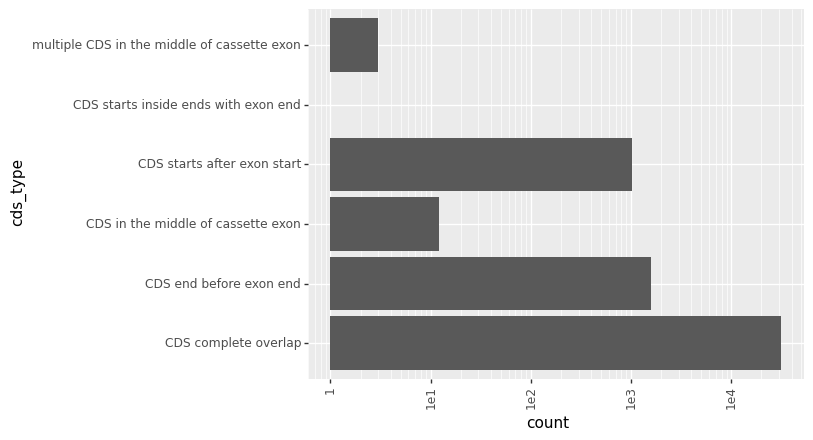

<ggplot: (1460184706405)>

In [30]:
(ggplot(exon_cds_ann_ascot_df, aes('cds_type'))
    + geom_bar()
    + scale_y_log10()
    + coord_flip()
    + theme(axis_text_x = element_text(angle=90)))

In [31]:
len_unique_ascot_ensembl_exons = len(exon_ascot_ensembl_df.loc[:, ['Start','End', 'Chromosome','Strand']].drop_duplicates())
len_unique_ascot_ensembl_exons

35824

All cds annotated accsette exons common to ensembl and ASCOT:

In [32]:
len_unique_cds_exons_ascot_ensembl = len(exon_cds_ann_ascot_df.loc[:, ['Start','End', 'Chromosome','Strand']].drop_duplicates())
len_unique_cds_exons_ascot_ensembl

33340

This is the ratio of cassette exons which were not part of any annotated CDS or were part of UTRs

In [33]:
1-len_unique_cds_exons_ascot_ensembl/len_unique_ascot_ensembl_exons

0.06933899062081283

Let's work with cassette exons which fully contain a part of the coding sequence not containing start or stop codons.

In [34]:
exon_cds_ann_ascot_df = exon_cds_ann_ascot_df[exon_cds_ann_ascot_df['cds_type']=='CDS complete overlap']
exon_cds_ann_ascot_df

,gene_id,Start,End,Chromosome,Start_cds,End_cds,Strand,Frame,cds_type
1,ENSG00000000005.5,100599015.0,100599182.0,chrX,100599015.0,100599182.0,+,2,CDS complete overlap
2,ENSG00000000419.12,50945736.0,50945762.0,chr20,50945736.0,50945762.0,-,0,CDS complete overlap
3,ENSG00000000457.13,169873695.0,169873752.0,chr1,169873695.0,169873752.0,-,0,CDS complete overlap
4,ENSG00000000457.13,169870254.0,169870357.0,chr1,169870254.0,169870357.0,-,0,CDS complete overlap
5,ENSG00000000457.13,169855795.0,169855957.0,chr1,169855795.0,169855957.0,-,2,CDS complete overlap
...,...,...,...,...,...,...,...,...,...
34290,ENSG00000283652.1,48775711.0,48775806.0,chr10,48775711.0,48775806.0,+,1,CDS complete overlap
34291,ENSG00000283652.1,48777418.0,48777495.0,chr10,48777418.0,48777495.0,+,1,CDS complete overlap
34292,ENSG00000283652.1,48779940.0,48780119.0,chr10,48779940.0,48780119.0,+,2,CDS complete overlap
34293,ENSG00000283654.1,23101291.0,23101564.0,chr14,23101291.0,23101564.0,-,0,CDS complete overlap


All cds annotated cassette exons common to ensembl and ASCOT with full CDS overlap:

In [35]:
cds_ascot_ensembl_overlap = len(exon_cds_ann_ascot_df.loc[:, ['Start','End', 'Chromosome','Strand']].drop_duplicates())
cds_ascot_ensembl_overlap

30877

Ratio of cassette exons that fully overlap a CDS compared to all cassette exons

In [36]:
cds_ascot_ensembl_overlap/len_unique_cds_exons_ascot_ensembl

0.926124775044991

## Get CDS of cassette exons

In [37]:
from kipoiseq.extractors import FastaStringExtractor
from data_utils.sequence_utils import codons_count
from pybedtools import Interval

In [38]:
fae = FastaStringExtractor(fasta_file=data_path+'hg38.fa', use_strand=True, force_upper=True)
fae

In [39]:
def get_cds_seq(exon_row):
    #FastaStringExtractor is 0 based
    interval = Interval(str(exon_row.Chromosome), int(exon_row.Start_cds), int(exon_row.End_cds), strand=str(exon_row.Strand))
    seq = fae.extract(interval)
    return seq

In [40]:
exon_cds_ann_ascot_df['cds_seq'] = exon_cds_ann_ascot_df.apply(get_cds_seq, axis=1)

/opt/modules/i12g/anaconda/envs/mrna_halflife2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
exon_cds_ann_ascot_df

,gene_id,Start,End,Chromosome,Start_cds,End_cds,Strand,Frame,cds_type,cds_seq
1,ENSG00000000005.5,100599015.0,100599182.0,chrX,100599015.0,100599182.0,+,2,CDS complete overlap,TTTCTGAGTTACAAGACTTTGAGGAGGAGGGAGAAGATCTTCACTT...
2,ENSG00000000419.12,50945736.0,50945762.0,chr20,50945736.0,50945762.0,-,0,CDS complete overlap,CCAAAATTTATTCCTGAATTTATTAG
3,ENSG00000000457.13,169873695.0,169873752.0,chr1,169873695.0,169873752.0,-,0,CDS complete overlap,TTTCTGAGGAGTATTCAGTCAATAAGAGACCCAGCATCTATCCCTC...
4,ENSG00000000457.13,169870254.0,169870357.0,chr1,169870254.0,169870357.0,-,0,CDS complete overlap,TCTCCAGAATTCACAACTCTCCCAGAGTGTCATGGACATGCCCGGG...
5,ENSG00000000457.13,169855795.0,169855957.0,chr1,169855795.0,169855957.0,-,2,CDS complete overlap,ATTCTCCTATGTGTGTCGTCTGCAGCCATCACAGTCAGATCTCGCC...
...,...,...,...,...,...,...,...,...,...,...
34290,ENSG00000283652.1,48775711.0,48775806.0,chr10,48775711.0,48775806.0,+,1,CDS complete overlap,ACAGTTTCTAGGTCTTGGAATTCCCTCATCTCTGTCGGCCACAACA...
34291,ENSG00000283652.1,48777418.0,48777495.0,chr10,48777418.0,48777495.0,+,1,CDS complete overlap,CTGTTTGTTTATTCCAACCCTGTCCACAGTTATGGGAACCAGCACT...
34292,ENSG00000283652.1,48779940.0,48780119.0,chr10,48779940.0,48780119.0,+,2,CDS complete overlap,ATGTCATGGAACCTGAGGATGACTCCGAGCCTTCTGCAGGATGCCA...
34293,ENSG00000283654.1,23101291.0,23101564.0,chr14,23101291.0,23101564.0,-,0,CDS complete overlap,AGTGAATGCTGGAAGAAGGAAAACGGATTCCCTGCTGGGGTGGATA...


Get exon ids:

In [42]:
exon_cds_ann_ascot_df = cassete_exon_coding_df.loc[:, ['exon_id','Start','End', 'Strand', 'Chromosome']].merge(exon_cds_ann_ascot_df, on=['Start','End', 'Strand', 'Chromosome'])

In [43]:
exon_cds_ann_ascot_df

,exon_id,Start,End,Strand,Chromosome,gene_id,Start_cds,End_cds,Frame,cds_type,cds_seq
0,GT_00001,58352097,58352184,-,chr19,ENSG00000121410.11,58352097.0,58352184.0,2,CDS complete overlap,GACCAGGTCCAGGAAGCTGGCCACACGGTTGCCTGGGTCTGATGGT...
1,GT_00005,50828130,50828295,-,chr10,ENSG00000148584.14,50828130.0,50828295.0,2,CDS complete overlap,GAAGAATTCAGTTATGGGGACATGGTATTGCAGTAGACTGGGCAGA...
2,GT_00007,50841861,50841992,-,chr10,ENSG00000148584.14,50841861.0,50841992.0,0,CDS complete overlap,ATCGGTAAAATTTATGAAATGAGAATGATGATGGATTTTAATGGCA...
3,GT_00010,9072358,9072486,-,chr12,ENSG00000175899.14,9072358.0,9072486.0,0,CDS complete overlap,ACATCCTTGAAATACAATATTCTCCCAGAAAAGGAAGAGTTCCCCT...
4,GT_00011,9079638,9079815,-,chr12,ENSG00000175899.14,9079638.0,9079815.0,2,CDS complete overlap,GAGACATATTAGGCTCTGCCATGCAAAACACACAAAATCTTCTCCA...
...,...,...,...,...,...,...,...,...,...,...,...
31666,GT_80010,4116971,4117166,-,chr17,ENSG00000074755.14,4116971.0,4117166.0,2,CDS complete overlap,GTTTCACAGACATATTTTCAGAGTCGAAGGAGGGCCTTGATATTCA...
31667,GT_80011,4123906,4124051,-,chr17,ENSG00000074755.14,4123906.0,4124051.0,0,CDS complete overlap,GCCTTTGCCCAGTTTGATGCTGAGGGTGATGGGACAGTTGATGCCG...
31668,GT_80012,77566080,77566181,-,chr1,ENSG00000036549.12,77566080.0,77566181.0,0,CDS complete overlap,TGTGATAACTGTGGCATAGAACCCATCCAGGGTGTTCGGTGGCATT...
31669,GT_80013,77568331,77568466,-,chr1,ENSG00000036549.12,77568331.0,77568466.0,0,CDS complete overlap,GATGACGAAAGTATTCCTATCATGTATAGGAATTTACCTGAATATA...


In [44]:
exon_cds_ann_ascot_df.loc[exon_cds_ann_ascot_df.exon_id.duplicated()]

,exon_id,Start,End,Strand,Chromosome,gene_id,Start_cds,End_cds,Frame,cds_type,cds_seq
181,GT_00331,48100871,48101009,-,chr16,ENSG00000140798.15,48100871.0,48101009.0,0,CDS complete overlap,CATTTTCCACAGAGGAGTCCAGGAGCTCAAGAAGGTGGAGAATGTC...
193,GT_00346,50660922,50661114,+,chr17,ENSG00000108846.15,50660922.0,50661114.0,0,CDS complete overlap,ACACAAGGCTTCAGCAGCACCTGGGAAAAATGCCTCCGGCGAGGAC...
244,GT_00436,74288206,74288259,-,chr14,ENSG00000119688.20,74288206.0,74288259.0,1,CDS complete overlap,TCCAACTTGGTGGCAAGGACAGAGGGCCTGGACCAGCAGGTGGACT...
288,GT_00528,51978258,51978374,+,chr3,ENSG00000248487.8,51978258.0,51978374.0,1,CDS complete overlap,GGTGGAGGTGGTGCTGCTTCATGGAAAGGCCTTTAACTCTCACACG...
290,GT_00529,51980392,51980628,+,chr3,ENSG00000248487.8,51980392.0,51980628.0,2,CDS complete overlap,GTTTTGGGAACTCGGCACCTTCAAAGGAGGCAAGCACAGAGGCAGG...
...,...,...,...,...,...,...,...,...,...,...,...
31527,GT_79516,11495949,11496165,-,chr19,ENSG00000267477.1,11495949.0,11496165.0,2,CDS complete overlap,GGCGGCGACGCAACGTGAACTGCCTGAAGAACGTGGTGATCTGGTA...
31556,GT_79670,11977370,11977431,+,chr19,ENSG00000267179.1,11977370.0,11977431.0,2,CDS complete overlap,GGAAAAAGTGGAAAGACCAGAACATTGAATATGAGTACCAAAACCC...
31580,GT_79809,12046367,12046428,-,chr19,ENSG00000257446.3,12046367.0,12046428.0,2,CDS complete overlap,GAAAAAAATGGAACAACCAGTACATTGAAGATGAGCACCAAAATCC...
31610,GT_79904,43368922,43369127,-,chr15,ENSG00000140265.12,43368922.0,43369127.0,2,CDS complete overlap,GTCACAGTCTCTGTGAAGGGGCAGGAAGTGCGCTTGGAGAAGATGA...


In [45]:
len(exon_cds_ann_ascot_df['exon_id'].unique())

30877

A minority of exons have fully overlapping CDS but more versions from different CDS frames

In [46]:
exon_cds_ann_ascot_df.iloc[180:182, :]

,exon_id,Start,End,Strand,Chromosome,gene_id,Start_cds,End_cds,Frame,cds_type,cds_seq
180,GT_00331,48100871,48101009,-,chr16,ENSG00000140798.15,48100871.0,48101009.0,1,CDS complete overlap,CATTTTCCACAGAGGAGTCCAGGAGCTCAAGAAGGTGGAGAATGTC...
181,GT_00331,48100871,48101009,-,chr16,ENSG00000140798.15,48100871.0,48101009.0,0,CDS complete overlap,CATTTTCCACAGAGGAGTCCAGGAGCTCAAGAAGGTGGAGAATGTC...


In [47]:
exon_cds_ann_ascot_df.to_csv(data_path+'cassette_ascot_ensembl_cds.csv')

## Get tissue-specific cassette exons

In [49]:
#exon_cds_ann_ascot_df = pd.read_csv(data_path+'cassette_ascot_ensembl_cds.csv',index_col=0)
#exon_cds_ann_ascot_df

Let's get the psi for all cassette exons with annotated CDS:

In [50]:
all_exon_ann_psi_df = cassete_exon_coding_df[cassete_exon_coding_df['exon_id'].isin(exon_cds_ann_ascot_df['exon_id'])]
all_exon_ann_psi_df

,Chromosome,Start,End,exon_id,cassette_exon,alternative_splice_site_group,linked_exons,mutually_exclusive_exons,Strand,exon_length,...,Not Sun Exposed - Skin,Sun Exposed (Lower leg) - Skin,Ileum - Small Intestine,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,chr19,58352097,58352184,GT_00001,Yes,No,No,No,-,87,...,0.131990,0.121355,0.071895,0.126567,0.104978,0.085126,0.180842,0.085288,0.074392,0.099999
1,chr10,50828130,50828295,GT_00005,Yes,No,No,No,-,165,...,NaN,NaN,0.938369,0.960770,0.983744,NaN,NaN,NaN,NaN,0.982356
3,chr10,50841861,50841992,GT_00007,Yes,No,No,No,-,131,...,NaN,NaN,0.991756,NaN,0.937739,NaN,NaN,NaN,NaN,1.000000
6,chr12,9072358,9072486,GT_00010,Yes,No,No,No,-,128,...,0.998836,0.999364,0.999534,0.999745,0.999442,0.999500,0.999703,0.999503,0.999662,0.999503
7,chr12,9079638,9079815,GT_00011,Yes,No,No,No,-,177,...,0.999310,0.999604,0.999543,0.999597,0.999550,0.999610,0.999463,0.999410,0.999628,0.999634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56816,chr17,4116971,4117166,GT_80010,Yes,No,No,No,-,195,...,0.995624,0.995135,0.992367,0.999086,0.993889,0.993605,0.997296,0.995585,0.998226,0.989914
56817,chr17,4123906,4124051,GT_80011,Yes,No,No,No,-,145,...,0.996719,0.993593,0.993025,0.997290,0.997419,0.983452,0.997012,1.000000,0.997783,0.995828
56818,chr1,77566080,77566181,GT_80012,Yes,No,No,No,-,101,...,0.999714,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999819,1.000000
56819,chr1,77568331,77568466,GT_80013,Yes,No,No,No,-,135,...,0.997574,0.997801,0.996605,0.995835,0.998037,0.997400,0.997894,0.998358,0.999424,0.999307


Some exons have different cds annotations.

In [51]:
all_exon_ann_psi_df['ref_psi'] = all_exon_ann_psi_df.loc[:, tissues].mean(axis=1)

/opt/modules/i12g/anaconda/envs/mrna_halflife2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
all_exon_ann_psi_df['ref_psi']

0        0.078195
1        0.968174
3        0.984141
6        0.999516
7        0.999445
           ...   
56816    0.994601
56817    0.996214
56818    0.999841
56819    0.997810
56820    0.990311
Name: ref_psi, Length: 30877, dtype: float64

In [53]:
delta_psi_exon_df = all_exon_ann_psi_df.copy()

In [54]:
delta_psi_exon_df.loc[:, tissues] = delta_psi_exon_df.loc[:, tissues].sub(delta_psi_exon_df['ref_psi'], axis=0)

Threshold to consider an exon differentially spliced:

In [55]:
splice_thresh=0.2

In [56]:
delta_psi_exon_df.loc[:, tissues] = np.abs(delta_psi_exon_df.loc[:, tissues])>splice_thresh

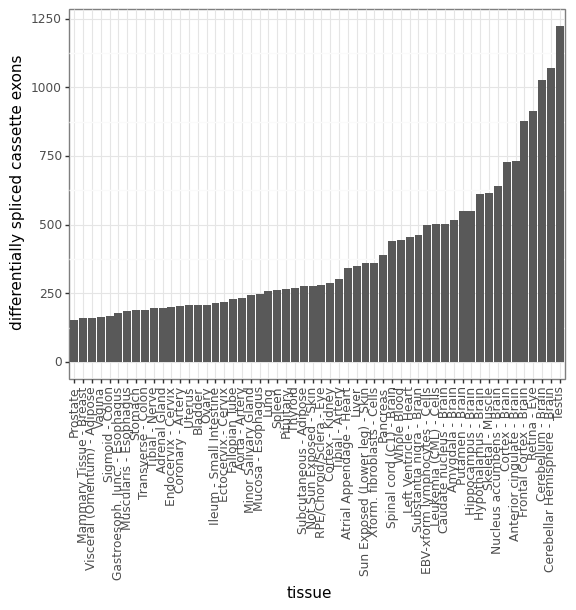

<ggplot: (1460030756901)>

In [57]:
diff_exons_sum_df = delta_psi_exon_df.loc[:, tissues].sum(axis=0).to_frame().reset_index().rename({'index':'tissue',0:'differentially spliced cassette exons'},axis=1)
diff_exons_sum_df['tissue'] = pd.Categorical(values=diff_exons_sum_df['tissue'], categories=diff_exons_sum_df.sort_values('differentially spliced cassette exons').loc[:, 'tissue'], ordered=True)

(ggplot(diff_exons_sum_df, aes('tissue','differentially spliced cassette exons'))
    + geom_col()
    + theme_bw()
    + theme(axis_text_x=element_text(angle=90)))

/opt/modules/i12g/anaconda/envs/mrna_halflife2/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_count : Removed 26866 rows containing non-finite values.


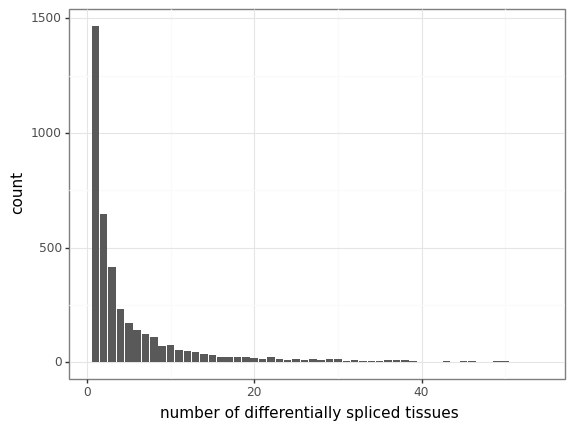

<ggplot: (1459988983421)>

In [58]:
diff_tissues = delta_psi_exon_df.loc[:, tissues].sum(axis=1).to_frame().rename({0:'number of differentially spliced tissues'},axis=1)
(ggplot(diff_tissues[diff_tissues>0], aes('number of differentially spliced tissues'))
    + theme_bw()
    + geom_bar())

Let's get a melted dataframe with all psi_diff for all exons on all tissues:

In [59]:
delta_psi_exon_df = all_exon_ann_psi_df.copy()

In [60]:
delta_psi_exon_df.loc[:, tissues] = delta_psi_exon_df.loc[:, tissues].sub(delta_psi_exon_df['ref_psi'], axis=0)

In [61]:
diff_exon_tissue_melted_df = delta_psi_exon_df.melt(id_vars='exon_id', value_vars=tissues, var_name='tissue', value_name='psi_diff').dropna()
diff_exon_tissue_melted_df

,exon_id,tissue,psi_diff
3,GT_00010,Retina - Eye,0.000484
4,GT_00011,Retina - Eye,0.000223
5,GT_00012,Retina - Eye,0.000709
6,GT_00013,Retina - Eye,0.002245
7,GT_00014,Retina - Eye,0.000182
...,...,...,...
1729107,GT_80010,Whole Blood,-0.004687
1729108,GT_80011,Whole Blood,-0.000386
1729109,GT_80012,Whole Blood,0.000159
1729110,GT_80013,Whole Blood,0.001497


## Decoding rate of cassette exons vs the COMD coefficient

### Calculate decoding rate

Let's load the codon decoding time calculated by Tuller et al

In [62]:
cdt_df = pd.read_csv(data_path + 'cdt_tuller_organisms.csv', sep=';').dropna().set_index('Codon')
cdt_df

,S. cerevisiae Exponential,S.cerevisiae Exponential gb15,S.cerevisiae Exponential A14201,S.cerevisiae DNA replication,S.cerevisiae Recombination,S.cerevisiae Metaphase I,S.cerevisiae Metaphase II,S.cerevisiae Anaphase,S.cerevisiae Spore packing,S.cerevisiae Spores,E. coli,B. subtilis,C. elegans L4 stage,C. elegans L2 stage,C. elegans L1 stage,M. musculus Embryonic stem cells,M. musculus Neutrophils,M. musculus Embryonic fibroblast,H. sapiens HEK293
Codon,,,,,,,,,,,,,,,,,,,
AAA,0.23777,0.18508,0.26467,0.23883,0.23600,0.25655,0.16069,0.23192,0.16552,0.26032,0.01300,0.00313,0.09245,0.22429,0.07418,0.2777,0.15340,0.12253,0.14788
AAC,0.17145,0.16424,0.23232,0.22061,0.21005,0.25208,0.18235,0.21784,0.15093,0.20437,0.01326,0.00457,0.07610,0.19341,0.06524,0.2859,0.15458,0.12729,0.14034
AAG,0.16835,0.16055,0.23711,0.21154,0.20497,0.24865,0.16129,0.23468,0.14522,0.19246,0.01307,0.00829,0.07463,0.16948,0.06151,0.2937,0.14941,0.12000,0.12458
AAT,0.23380,0.18375,0.24415,0.23656,0.22015,0.24921,0.15216,0.21694,0.15275,0.17679,0.01529,0.00490,0.09727,0.25872,0.08098,0.2774,0.16517,0.15045,0.15498
ACA,0.22216,0.15609,0.22937,0.20197,0.18404,0.20956,0.13864,0.20712,0.12563,0.18392,0.02404,0.00384,0.09095,0.21920,0.07702,0.2697,0.16845,0.13445,0.15344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.17474,0.13900,0.21468,0.19638,0.19419,0.21593,0.14801,0.22058,0.11242,0.17343,0.01871,0.00669,0.09591,0.24538,0.08611,0.2576,0.15000,0.14858,0.16268
TTA,0.21889,0.16798,0.20989,0.22580,0.20529,0.26297,0.18429,0.24457,0.15012,0.18423,0.02154,0.00416,0.10484,0.28296,0.08532,0.2731,0.17082,0.13965,0.17189
TTC,0.16125,0.16908,0.24608,0.21388,0.20167,0.24664,0.16072,0.23636,0.14740,0.19941,0.01557,0.00337,0.08152,0.22286,0.06956,0.2456,0.13383,0.13622,0.14625


Let's calcualte the mtdr. The mtdr is calculated by performing the geometric mean of the decoding rates of all codons on a transcript.

First we need to get the codon counts for all exons

In [63]:
def get_codon_counts(exon_row):
    
    frame = int(exon_row.Frame)
    #number of last bases with codon split between 2 exons:
    last_bases_codon = (len(exon_row.cds_seq)-frame) % 3 
    # From ensembl: frame - One of '0', '1' or '2'. '0' indicates that the first base of the feature is the first base of a codon, '1' that the second base is the first base of a codon, and so on..

    seq = exon_row.cds_seq[:-last_bases_codon] if last_bases_codon % 3 != 0 else exon_row.cds_seq
    codon_counts_df = codons_count(seq, frame=int(exon_row.Frame)).T
    
    if (codon_counts_df.sum(axis=1).values[0] == 0) & (len(seq)<3):
        print('exon with CDS with lower than 3 bp long')
    
    return codon_counts_df

In [64]:
exons_codon_counts_list = list(exon_cds_ann_ascot_df.apply(get_codon_counts, axis=1))

In [65]:
exons_codon_counts_df = pd.concat(exons_codon_counts_list, axis=0).reset_index(drop=True)
exons_codon_counts_df

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0
1,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0
2,2.0,1.0,2.0,6.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,2.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0
4,0.0,3.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31666,0.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,...,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0
31667,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
31668,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0
31669,3.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0


In [66]:
exon_cds_ann_ascot_df

,exon_id,Start,End,Strand,Chromosome,gene_id,Start_cds,End_cds,Frame,cds_type,cds_seq
0,GT_00001,58352097,58352184,-,chr19,ENSG00000121410.11,58352097.0,58352184.0,2,CDS complete overlap,GACCAGGTCCAGGAAGCTGGCCACACGGTTGCCTGGGTCTGATGGT...
1,GT_00005,50828130,50828295,-,chr10,ENSG00000148584.14,50828130.0,50828295.0,2,CDS complete overlap,GAAGAATTCAGTTATGGGGACATGGTATTGCAGTAGACTGGGCAGA...
2,GT_00007,50841861,50841992,-,chr10,ENSG00000148584.14,50841861.0,50841992.0,0,CDS complete overlap,ATCGGTAAAATTTATGAAATGAGAATGATGATGGATTTTAATGGCA...
3,GT_00010,9072358,9072486,-,chr12,ENSG00000175899.14,9072358.0,9072486.0,0,CDS complete overlap,ACATCCTTGAAATACAATATTCTCCCAGAAAAGGAAGAGTTCCCCT...
4,GT_00011,9079638,9079815,-,chr12,ENSG00000175899.14,9079638.0,9079815.0,2,CDS complete overlap,GAGACATATTAGGCTCTGCCATGCAAAACACACAAAATCTTCTCCA...
...,...,...,...,...,...,...,...,...,...,...,...
31666,GT_80010,4116971,4117166,-,chr17,ENSG00000074755.14,4116971.0,4117166.0,2,CDS complete overlap,GTTTCACAGACATATTTTCAGAGTCGAAGGAGGGCCTTGATATTCA...
31667,GT_80011,4123906,4124051,-,chr17,ENSG00000074755.14,4123906.0,4124051.0,0,CDS complete overlap,GCCTTTGCCCAGTTTGATGCTGAGGGTGATGGGACAGTTGATGCCG...
31668,GT_80012,77566080,77566181,-,chr1,ENSG00000036549.12,77566080.0,77566181.0,0,CDS complete overlap,TGTGATAACTGTGGCATAGAACCCATCCAGGGTGTTCGGTGGCATT...
31669,GT_80013,77568331,77568466,-,chr1,ENSG00000036549.12,77568331.0,77568466.0,0,CDS complete overlap,GATGACGAAAGTATTCCTATCATGTATAGGAATTTACCTGAATATA...


In [67]:
exon_cds_ann_ascot_df = pd.concat([exon_cds_ann_ascot_df.reset_index(drop=True), exons_codon_counts_df], axis=1)
exon_cds_ann_ascot_df

,exon_id,Start,End,Strand,Chromosome,gene_id,Start_cds,End_cds,Frame,cds_type,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,GT_00001,58352097,58352184,-,chr19,ENSG00000121410.11,58352097.0,58352184.0,2,CDS complete overlap,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0
1,GT_00005,50828130,50828295,-,chr10,ENSG00000148584.14,50828130.0,50828295.0,2,CDS complete overlap,...,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0
2,GT_00007,50841861,50841992,-,chr10,ENSG00000148584.14,50841861.0,50841992.0,0,CDS complete overlap,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,GT_00010,9072358,9072486,-,chr12,ENSG00000175899.14,9072358.0,9072486.0,0,CDS complete overlap,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0
4,GT_00011,9079638,9079815,-,chr12,ENSG00000175899.14,9079638.0,9079815.0,2,CDS complete overlap,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31666,GT_80010,4116971,4117166,-,chr17,ENSG00000074755.14,4116971.0,4117166.0,2,CDS complete overlap,...,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0
31667,GT_80011,4123906,4124051,-,chr17,ENSG00000074755.14,4123906.0,4124051.0,0,CDS complete overlap,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
31668,GT_80012,77566080,77566181,-,chr1,ENSG00000036549.12,77566080.0,77566181.0,0,CDS complete overlap,...,0.0,2.0,0.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0
31669,GT_80013,77568331,77568466,-,chr1,ENSG00000036549.12,77568331.0,77568466.0,0,CDS complete overlap,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0


In [68]:
exon_cds_ann_ascot_df['cds_length'] = exon_cds_ann_ascot_df['End_cds'] - exon_cds_ann_ascot_df['Start_cds']

In [69]:
codons_to_use = pd.Index(ALL_CODONS_NAMES).drop(['TAG','TGA','TAA']) # remove stop codons
codons_to_use

Index(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA', 'AGC',
       'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC', 'CAG', 'CAT',
       'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG', 'CGT', 'CTA', 'CTC',
       'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT', 'GCA', 'GCC', 'GCG', 'GCT',
       'GGA', 'GGC', 'GGG', 'GGT', 'GTA', 'GTC', 'GTG', 'GTT', 'TAC', 'TAT',
       'TCA', 'TCC', 'TCG', 'TCT', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC', 'TTG',
       'TTT'],
      dtype='object')

In [70]:
codon_counts_df = exon_cds_ann_ascot_df.set_index('exon_id').loc[:, list(codons_to_use) + ['cds_length']]
codon_counts_df 

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGC,TGG,TGT,TTA,TTC,TTG,TTT,cds_length
exon_id,,,,,,,,,,,,,,,,,,,,,
GT_00001,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,87.0
GT_00005,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,...,0.0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,165.0
GT_00007,2.0,1.0,2.0,6.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,131.0
GT_00010,2.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,128.0
GT_00011,0.0,3.0,2.0,3.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GT_80010,0.0,1.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,...,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,195.0
GT_80011,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,145.0
GT_80012,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,101.0


In [71]:
cell_type='H. sapiens  HEK293'
counts_cdr_df = codon_counts_df.T.join(1/cdt_df.loc[:, cell_type], how='inner') #time to rate (1/)

In [72]:
counts_cdr_df

,GT_00001,GT_00005,GT_00007,GT_00010,GT_00011,GT_00012,GT_00013,GT_00014,GT_00015,GT_00016,...,GT_80006,GT_80007,GT_80008,GT_80009,GT_80010,GT_80011,GT_80012,GT_80013,GT_80014,H. sapiens HEK293
AAA,1.0,2.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,...,2.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,6.762240
AAC,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,7.125552
AAG,2.0,1.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,0.0,...,1.0,1.0,3.0,1.0,4.0,1.0,0.0,4.0,3.0,8.026971
AAT,0.0,2.0,6.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,2.0,3.0,2.0,2.0,0.0,1.0,0.0,6.452445
ACA,0.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,...,0.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,1.0,6.517205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,6.147037
TTA,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,5.817674
TTC,0.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,6.837607
TTG,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6.025185


In [73]:
all_exons = list(codon_counts_df.index)

Compute the geometric mean of the codon decoding rates (as in Tuller et al) per cassette exon:

In [74]:
mtdr_list = []
exon_columns=counts_cdr_df.columns[:-1]
for cds_i, exon in enumerate(counts_cdr_df.columns[:-1]):
    
    counts_tr_df = counts_cdr_df.iloc[:, [cds_i,-1]]
    counts_tr_df = counts_tr_df[counts_tr_df[exon]!=0]
    #We have to work in log scale otherwise the product or the powered rates would explode
    log_rates_powered = np.log(counts_tr_df[cell_type]) * counts_tr_df[exon]
    
    log_sum = np.sum(log_rates_powered)
    log_geom_mean = (1./np.sum(counts_tr_df[exon]))*log_sum
    geom_mean = np.exp(log_geom_mean)
    if geom_mean==np.inf:
        print(exon)
    mtdr_list.append(geom_mean)
    
mtdr_df = pd.DataFrame({'exon':exon_columns, 'mtdr':mtdr_list})
mtdr_df

,exon,mtdr
0,GT_00001,7.162565
1,GT_00005,6.730526
2,GT_00007,6.822028
3,GT_00010,6.918610
4,GT_00011,7.055262
...,...,...
31666,GT_80010,7.324603
31667,GT_80011,7.232914
31668,GT_80012,6.734224
31669,GT_80013,6.721021


### Getting exon cds length to total length ratio and filtering for CCDS exons/transcripts

In [75]:
ascot_ensembl_transcripts = gtf_df.merge(cassete_exon_coding_df.loc[:, ['Start','End','Strand', 'Chromosome']], on=['Start','End','Strand', 'Chromosome'])

In [76]:
ascot_ensembl_transcripts = ascot_ensembl_transcripts.transcript_id.unique()

In [77]:
len(ascot_ensembl_transcripts)

65601

In [78]:
gtf_ascot_ensembl_df = gtf_df[gtf_df['transcript_id'].isin(list(ascot_ensembl_transcripts))]
gtf_ascot_ensembl_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
720,chr1,HAVANA,transcript,923927,939291,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,NaN,NaN,NaN,ENSP00000411579.2,NaN
721,chr1,HAVANA,exon,923927,924948,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,1,ENSE00001637883.2,NaN,ENSP00000411579.2,NaN
722,chr1,HAVANA,CDS,924431,924948,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,1,ENSE00001637883.2,NaN,ENSP00000411579.2,NaN
723,chr1,HAVANA,start_codon,924431,924434,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,1,ENSE00001637883.2,NaN,ENSP00000411579.2,NaN
724,chr1,HAVANA,exon,925921,926013,.,+,.,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-011,3,cds_end_NF,OTTHUMT00000316521.3,2,ENSE00003794726.1,NaN,ENSP00000411579.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578063,chrY,HAVANA,stop_codon,23285498,23285501,.,+,0,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,23,ENSE00001659634.1,NaN,ENSP00000371870.4,NaN
2578064,chrY,HAVANA,exon,23289499,23289999,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,24,ENSE00001865723.1,NaN,ENSP00000371870.4,NaN
2578065,chrY,HAVANA,UTR,23219547,23219740,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,1,ENSE00001943922.1,NaN,ENSP00000371870.4,NaN
2578066,chrY,HAVANA,UTR,23285498,23285536,.,+,.,ENSG00000205944.11,protein_coding,...,KNOWN,DAZ2-002,1,appris_alternative_2,OTTHUMT00000102482.1,23,ENSE00001659634.1,NaN,ENSP00000371870.4,NaN


Let's only chooose coding sequences from the consensus coding sequence

In [79]:
gtf_ascot_ensembl_cds_df = gtf_ascot_ensembl_df[(gtf_ascot_ensembl_df.transcript_type=='protein_coding') & 
                                                (gtf_ascot_ensembl_df.Feature=='CDS') & (~gtf_ascot_ensembl_df['ccdsid'].isna())]

In [80]:
gtf_ascot_ensembl_cds_df

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_status,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
753,chr1,HAVANA,CDS,925941,926013,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,2,ENSE00001763717.1,NaN,ENSP00000342313.3,CCDS2.2
756,chr1,HAVANA,CDS,930154,930336,.,+,0,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,3,ENSE00002727207.1,NaN,ENSP00000342313.3,CCDS2.2
758,chr1,HAVANA,CDS,931038,931089,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,4,ENSE00002696520.1,NaN,ENSP00000342313.3,CCDS2.2
760,chr1,HAVANA,CDS,935771,935896,.,+,1,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,5,ENSE00002703998.1,NaN,ENSP00000342313.3,CCDS2.2
762,chr1,HAVANA,CDS,939039,939129,.,+,2,ENSG00000187634.11,protein_coding,...,KNOWN,SAMD11-010,5,CCDS,OTTHUMT00000276866.2,6,ENSE00002686739.1,NaN,ENSP00000342313.3,CCDS2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577442,chrY,HAVANA,CDS,23152796,23152868,.,-,0,ENSG00000188120.14,protein_coding,...,KNOWN,DAZ1-001,5,CCDS,OTTHUMT00000102473.1,23,ENSE00001675126.1,NaN,ENSP00000384573.1,CCDS48209.1
2577444,chrY,HAVANA,CDS,23143010,23143082,.,-,0,ENSG00000188120.14,protein_coding,...,KNOWN,DAZ1-001,5,CCDS,OTTHUMT00000102473.1,24,ENSE00001697295.1,NaN,ENSP00000384573.1,CCDS48209.1
2577446,chrY,HAVANA,CDS,23140625,23140697,.,-,0,ENSG00000188120.14,protein_coding,...,KNOWN,DAZ1-001,5,CCDS,OTTHUMT00000102473.1,25,ENSE00001614454.1,NaN,ENSP00000384573.1,CCDS48209.1
2577448,chrY,HAVANA,CDS,23139846,23139881,.,-,0,ENSG00000188120.14,protein_coding,...,KNOWN,DAZ1-001,5,CCDS,OTTHUMT00000102473.1,26,ENSE00003674346.1,NaN,ENSP00000384573.1,CCDS48209.1


/opt/modules/i12g/anaconda/envs/mrna_halflife2/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 146'. Pick better value with 'binwidth'.


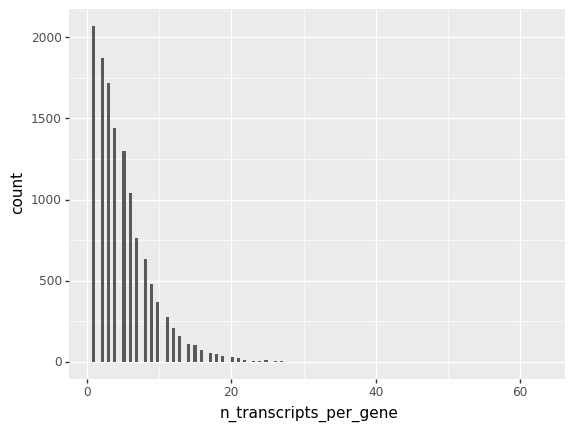

<ggplot: (1459986557393)>

In [81]:
num_tr_gene_df = gtf_ascot_ensembl_df.groupby('gene_id')['transcript_id'].unique().apply(lambda el: len(el)).to_frame().rename({'transcript_id':'n_transcripts_per_gene'}, axis=1)
(ggplot(num_tr_gene_df, aes('n_transcripts_per_gene'))
    + geom_histogram())

In [82]:
def get_transcript_cds_length(transcript_df):
    transcript_df['end_start_interval'] = transcript_df['End'] - transcript_df['Start']
    cds_length = transcript_df['end_start_interval'].sum()
    return cds_length

In [83]:
transcript_cds_len_df = gtf_ascot_ensembl_cds_df.groupby('transcript_id').apply(get_transcript_cds_length)
transcript_cds_len_df.name='full_cds_length'
transcript_cds_len_df = transcript_cds_len_df.to_frame()
transcript_cds_len_df

,full_cds_length
transcript_id,
ENST00000000233.9,540
ENST00000000412.7,831
ENST00000000442.10,1269
ENST00000001008.5,1377
ENST00000001146.6,1536
...,...
ENST00000638009.1,6783
ENST00000638035.1,1470
ENST00000638045.1,13413


Let's get the exon id - transcript id correspondence for the CDS consensus exons:

In [84]:
exon_id_transcript_df = gtf_ascot_ensembl_cds_df.drop('exon_id', axis=1).merge(cassete_exon_coding_df.loc
                                                                      [:, ['Start','End','Strand', 'Chromosome', 'exon_id']], 
                                                                      on=['Start','End','Strand', 'Chromosome']).loc[:, ['exon_id','transcript_id']].drop_duplicates()
exon_id_transcript_df

,exon_id,transcript_id
0,GT_60772,ENST00000342066.7
1,GT_60773,ENST00000342066.7
2,GT_45171,ENST00000327044.6
3,GT_45168,ENST00000327044.6
4,GT_35077,ENST00000338591.7
...,...,...
60300,GT_22037,ENST00000382772.3
60301,GT_55444,ENST00000382659.6
60302,GT_55445,ENST00000250831.5
60303,GT_18262,ENST00000405239.5


In [85]:
len(exon_id_transcript_df['exon_id'].unique())

29430

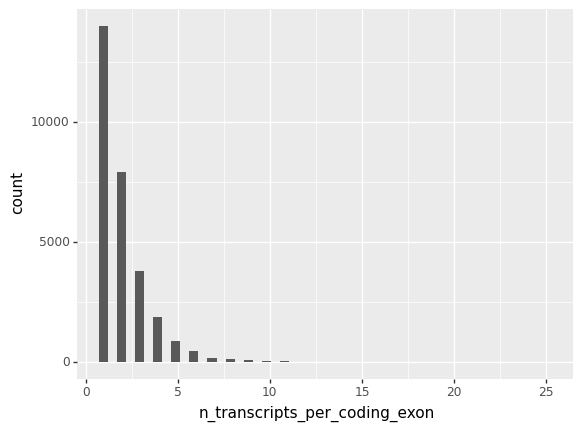

<ggplot: (1459986258581)>

In [86]:
num_tr_gene_df = exon_id_transcript_df.groupby('exon_id')['transcript_id'].unique().apply(lambda el: len(el)).to_frame().rename({'transcript_id':'n_transcripts_per_coding_exon'}, axis=1)
(ggplot(num_tr_gene_df, aes('n_transcripts_per_coding_exon'))
    + geom_histogram(bins=50))

All CCDS coding sequences are multiples of 3

In [87]:
(transcript_cds_len_df['full_cds_length']%3==0).sum()/len(transcript_cds_len_df)

1.0

Let's merge the transcripts cds lengths and exons with coding sequences:

In [88]:
len(exon_id_transcript_df.merge(transcript_cds_len_df, left_on='transcript_id', right_index=True)['exon_id'].unique())

29430

In [89]:
transcript_cds_len_df = exon_id_transcript_df.merge(transcript_cds_len_df, left_on='transcript_id', right_index=True)
transcript_cds_len_df

,exon_id,transcript_id,full_cds_length
0,GT_60772,ENST00000342066.7,2043
1,GT_60773,ENST00000342066.7,2043
2,GT_45171,ENST00000327044.6,2247
3,GT_45168,ENST00000327044.6,2247
4,GT_35077,ENST00000338591.7,1926
...,...,...,...
60300,GT_22037,ENST00000382772.3,381
60301,GT_55444,ENST00000382659.6,1488
60302,GT_55445,ENST00000250831.5,1488
60303,GT_18262,ENST00000405239.5,2232


### Diff spliced exons decoding rate vs COMD coefficient

In [90]:
ascot_gtex_tissue_cor_dict = {'Subcutaneous - Adipose':'Adipose - Subcutaneous',
 'Visceral (Omentum) - Adipose':'Adipose - Visceral (Omentum)',
 'Adrenal Gland':'Adrenal Gland',
 'Aorta - Artery': 'Artery - Aorta',
 'Coronary - Artery': 'Artery - Coronary',
 'Tibial - Artery':'Artery - Tibial',
 'Amygdala - Brain':'Brain - Amygdala',
 'Anterior cingulate - Brain':'Brain - Anterior cingulate cortex (BA24)',
 'Caudate nucleus - Brain':'Brain - Caudate (basal ganglia)',
 'Cerebellar Hemisphere - Brain':'Brain - Cerebellar Hemisphere',
 'Cerebellum - Brain':'Brain - Cerebellum',
 'Cortex - Brain':'Brain - Cortex',
 'Frontal Cortex - Brain':'Brain - Frontal Cortex (BA9)',
 'Hippocampus - Brain':'Brain - Hippocampus',
 'Hypothalamus - Brain':'Brain - Hypothalamus',
 'Nucleus accumbens - Brain':'Brain - Nucleus accumbens (basal ganglia)',
 'Putamen - Brain':'Brain - Putamen (basal ganglia)',
 'Spinal cord (C1) - Brain':'Brain - Spinal cord (cervical c-1)',
 'Substantia nigra - Brain':'Brain - Substantia nigra',
 'Mammary Tissue - Breast':'Breast - Mammary Tissue',
 'EBV-xform lymphocytes - Cells':'Cells - EBV-transformed lymphocytes',
 'Xform. fibroblasts - Cells':'Cells - Transformed fibroblasts',
 'Sigmoid - Colon':'Colon - Sigmoid',
 'Transverse - Colon':'Colon - Transverse',
 'Gastroesoph. Junc. - Esophagus':'Esophagus - Gastroesophageal Junction',
 'Mucosa - Esophagus':'Esophagus - Mucosa',
 'Muscularis - Esophagus':'Esophagus - Muscularis',
 'Atrial Appendage - Heart':'Heart - Atrial Appendage',
 'Left Ventricle - Heart':'Heart - Left Ventricle',
 'Cortex - Kidney':'Kidney - Cortex',
 'Liver':'Liver',
 'Lung':'Lung',
 'Minor Salivary Gland':'Minor Salivary Gland',
 'Skeletal - Muscle':'Muscle - Skeletal',
 'Tibial - Nerve':'Nerve - Tibial',
 'Ovary':'Ovary',
 'Pancreas':'Pancreas',
 'Pituitary':'Pituitary',
 'Prostate':'Prostate',
 'Not Sun Exposed - Skin':'Skin - Not Sun Exposed (Suprapubic)',
 'Sun Exposed (Lower leg) - Skin':'Skin - Sun Exposed (Lower leg)',
 'Ileum - Small Intestine':'Small Intestine - Terminal Ileum',
 'Spleen':'Spleen',
 'Stomach':'Stomach',
 'Testis':'Testis',
 'Thyroid':'Thyroid',
 'Uterus':'Uterus',
 'Vagina':'Vagina',
 'Whole Blood':'Whole Blood'}
gtex_ascot_tissue_cor_dict = {y:x for x,y in ascot_gtex_tissue_cor_dict.items()}

In [91]:
len(gtex_ascot_tissue_cor_dict)

49

In [92]:
comd_coef_df = pd.read_csv(data_path+'comd_coef_subtissues.csv',index_col=0)
len(comd_coef_df)

49

In [93]:
comd_coef_df = comd_coef_df.replace(gtex_ascot_tissue_cor_dict)
comd_coef_df

,tissue,comd_coef
9,Cerebellar Hemisphere - Brain,-0.554226
12,Frontal Cortex - Brain,-0.527138
14,Hypothalamus - Brain,-0.511458
15,Nucleus accumbens - Brain,-0.452002
7,Anterior cingulate - Brain,-0.449694
8,Caudate nucleus - Brain,-0.439502
18,Substantia nigra - Brain,-0.428226
6,Amygdala - Brain,-0.414525
13,Hippocampus - Brain,-0.408580
21,Xform. fibroblasts - Cells,-0.401583


In [94]:
comd_coef_diff_df = diff_exon_tissue_melted_df.merge(comd_coef_df, on='tissue')
comd_coef_diff_df = comd_coef_diff_df.merge(mtdr_df, left_on='exon_id',right_on='exon')
comd_coef_diff_df

,exon_id,tissue,psi_diff,comd_coef,exon,mtdr
0,GT_00001,Subcutaneous - Adipose,-0.021693,0.370405,GT_00001,7.162565
1,GT_00001,Visceral (Omentum) - Adipose,0.044648,0.176653,GT_00001,7.162565
2,GT_00001,Adrenal Gland,0.028491,-0.191577,GT_00001,7.162565
3,GT_00001,Aorta - Artery,0.010912,0.269390,GT_00001,7.162565
4,GT_00001,Coronary - Artery,0.004870,0.109317,GT_00001,7.162565
...,...,...,...,...,...,...
1442854,GT_72714,Testis,0.000000,-0.228302,GT_72714,7.083191
1442855,GT_76943,Testis,0.000000,-0.228302,GT_76943,6.696915
1442856,GT_76944,Testis,0.000000,-0.228302,GT_76944,7.067914
1442857,GT_79602,Testis,0.000000,-0.228302,GT_79602,6.961231


In [95]:
comd_coef_diff_len_df = comd_coef_diff_df.merge(transcript_cds_len_df, on='exon_id')
comd_coef_diff_len_df

,exon_id,tissue,psi_diff,comd_coef,exon,mtdr,transcript_id,full_cds_length
0,GT_00010,Subcutaneous - Adipose,-0.000088,0.370405,GT_00010,6.918610,ENST00000318602.11,4422
1,GT_00010,Visceral (Omentum) - Adipose,-0.000427,0.176653,GT_00010,6.918610,ENST00000318602.11,4422
2,GT_00010,Adrenal Gland,0.000237,-0.191577,GT_00010,6.918610,ENST00000318602.11,4422
3,GT_00010,Aorta - Artery,0.000192,0.269390,GT_00010,6.918610,ENST00000318602.11,4422
4,GT_00010,Coronary - Artery,0.000138,0.109317,GT_00010,6.918610,ENST00000318602.11,4422
...,...,...,...,...,...,...,...,...
2876099,GT_72183,Testis,0.142370,-0.228302,GT_72183,6.858530,ENST00000427445.6,1539
2876100,GT_72183,Testis,0.142370,-0.228302,GT_72183,6.858530,ENST00000612746.1,1239
2876101,GT_72714,Testis,0.000000,-0.228302,GT_72714,7.083191,ENST00000332517.3,1404
2876102,GT_79602,Testis,0.000000,-0.228302,GT_79602,6.961231,ENST00000400120.3,900


In [96]:
ccds_diff_spliced_exons = len(comd_coef_diff_len_df['exon_id'].unique())
ccds_diff_spliced_exons

29417

In [97]:
all_diff_spliced_exons = len(comd_coef_diff_df['exon_id'].unique())
all_diff_spliced_exons

30864

Ratio of non CCDS diff spliced exons to total diff spliced exons: 

In [98]:
(all_diff_spliced_exons-ccds_diff_spliced_exons)/all_diff_spliced_exons

0.046883100051840335

In [100]:
comd_coef_diff_len_df.to_csv('../../figures/figure_data/fig4/comd_coef_diff_spliced_exons_dec_rate.csv')

#### Positively differentially spliced exons

In [101]:
comd_coef_pos_diff_df = comd_coef_diff_len_df[comd_coef_diff_len_df['psi_diff']>=0.2]
comd_coef_pos_diff_df

,exon_id,tissue,psi_diff,comd_coef,exon,mtdr,transcript_id,full_cds_length
5873,GT_00204,Liver,0.255529,-0.040037,GT_00204,7.251387,ENST00000370225.3,6819
9435,GT_00263,Liver,0.218387,-0.040037,GT_00263,6.883317,ENST00000359206.7,3837
9436,GT_00263,Liver,0.218387,-0.040037,GT_00263,6.883317,ENST00000265723.8,3858
9463,GT_00263,Testis,0.321439,-0.228302,GT_00263,6.883317,ENST00000359206.7,3837
9464,GT_00263,Testis,0.321439,-0.228302,GT_00263,6.883317,ENST00000265723.8,3858
...,...,...,...,...,...,...,...,...
2876018,GT_09675,Testis,0.464735,-0.228302,GT_09675,6.659830,ENST00000326581.8,1077
2876055,GT_43045,Testis,0.477755,-0.228302,GT_43045,7.315554,ENST00000431443.6,3066
2876067,GT_51603,Testis,0.456920,-0.228302,GT_51603,6.585470,ENST00000356920.9,3225
2876069,GT_53043,Testis,0.422441,-0.228302,GT_53043,7.413665,ENST00000567164.5,1185


In [102]:
len(comd_coef_pos_diff_df.exon_id.unique())

1503

In [103]:
comd_coef_pos_diff_df['comd_coef_fc'] = 2**comd_coef_pos_diff_df['comd_coef']

/opt/modules/i12g/anaconda/envs/mrna_halflife2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


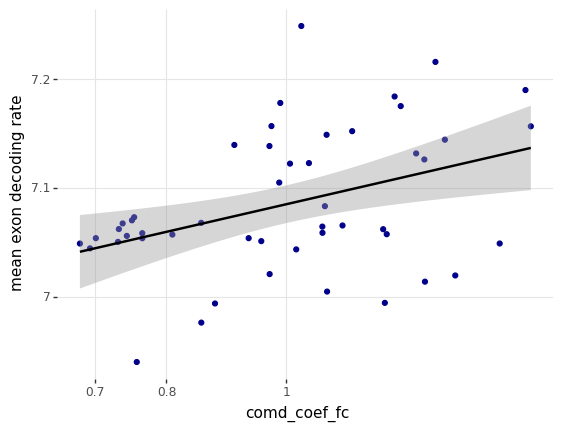

<ggplot: (1459986561921)>

In [104]:
(ggplot(comd_coef_pos_diff_df.groupby('tissue').mean(), aes('comd_coef_fc','mtdr'))
    + geom_point(color='darkblue')
    + theme_bw()
    + geom_smooth(method='lm')
    + scale_x_log10()
    + theme( #panel_grid_major = element_blank(),
                    panel_grid_minor = element_blank(),
                    #panel_border = element_blank(),
                    panel_background = element_blank()
           )
    +labs(y='mean exon decoding rate'))

In [105]:
df_median = comd_coef_pos_diff_df.groupby('tissue').mean().dropna()
spearmanr(df_median['comd_coef'], df_median['mtdr'])

SpearmanrResult(correlation=0.35020408163265304, pvalue=0.013632050394204565)

#### Negatively differentially spliced exons

In [106]:
comd_coef_neg_diff_df = comd_coef_diff_len_df[comd_coef_diff_len_df['psi_diff']<=-0.2]
comd_coef_neg_diff_df

,exon_id,tissue,psi_diff,comd_coef,exon,mtdr,transcript_id,full_cds_length
537,GT_00023,Atrial Appendage - Heart,-0.246558,0.264325,GT_00023,7.126612,ENST00000299698.11,4362
538,GT_00023,Atrial Appendage - Heart,-0.246558,0.264325,GT_00023,7.126612,ENST00000539547.5,2889
4783,GT_00159,Spinal cord (C1) - Brain,-0.253602,-0.306032,GT_00159,6.887413,ENST00000269081.8,4629
4965,GT_00164,Anterior cingulate - Brain,-0.274941,-0.449694,GT_00164,6.774134,ENST00000269081.8,4629
4967,GT_00164,Cerebellar Hemisphere - Brain,-0.492775,-0.554226,GT_00164,6.774134,ENST00000269081.8,4629
...,...,...,...,...,...,...,...,...
2875982,GT_18262,Not Sun Exposed - Skin,-0.441170,0.641855,GT_18262,6.699638,ENST00000405239.5,2232
2875986,GT_33877,Ileum - Small Intestine,-0.653656,0.060598,GT_33877,7.131417,ENST00000399881.7,3447
2876019,GT_09675,Uterus,-0.464735,0.372042,GT_09675,6.659830,ENST00000326581.8,1077
2876056,GT_43045,Thyroid,-0.477755,0.306996,GT_43045,7.315554,ENST00000431443.6,3066


In [107]:
len(comd_coef_neg_diff_df.exon_id.unique())

2658

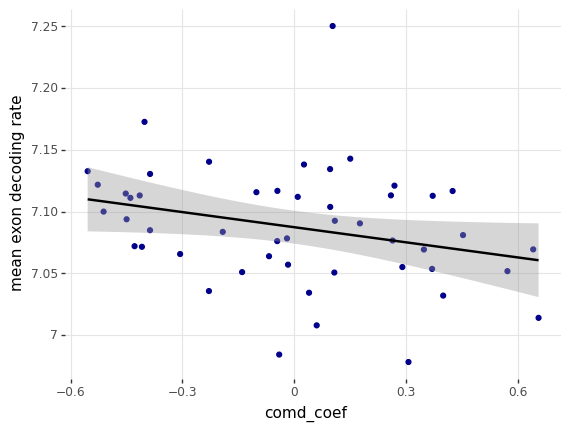

<ggplot: (1459985991621)>

In [108]:
(ggplot(comd_coef_neg_diff_df.groupby('tissue').mean(), aes('comd_coef','mtdr'))
    + geom_point(color='darkblue')
    + theme_bw()
    + geom_smooth(method='lm')
    + theme( #panel_grid_major = element_blank(),
                    panel_grid_minor = element_blank(),
                    #panel_border = element_blank(),
                    panel_background = element_blank()
           )
    +labs(y='mean exon decoding rate'))

In [109]:
df_median = comd_coef_neg_diff_df.groupby('tissue').mean().dropna()
spearmanr(df_median['comd_coef'], df_median['mtdr'])

SpearmanrResult(correlation=-0.3006122448979591, pvalue=0.03583648215333546)